# **Assignment 4 - Time-Series Analysis**
## Author: Jake Brulato
## Tuesday 5:30 - 8:15 : Kornelia

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv('gas_prod.csv',sep=',')
df

,Month,Gas_prod
0,1,384.261096
1,2,380.107310
2,3,392.967363
3,4,402.114680
4,5,393.519639
...,...,...
235,236,395.379147
236,237,395.330980
237,238,396.520100
238,239,391.428054


# **1. Generate a plot of the monthly gas production with proper labels.  Paste a screenshot in the Word document. (5)  Once you have read the csv data, before moving to any other step, use the following code to convert the “Month” column to a proper date column of equal monthly intervals.**
 
- Assume the sequence starts in January 2004 and ends in December 2023 (12 months x 20 years) 
- start_date = '2004-01' 
 
- Generate a date range starting from the start_date, with a frequency of one month, and length equal to the dataset 
- df['Date'] = pd.date_range(start=start_date, periods=len(df), freq='M') 

/var/folders/6s/bfbnxg_x46gfcltpcwwr67200000gn/T/ipykernel_8659/461444396.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Date'] = pd.date_range(start='2004-01', periods=len(df), freq='M')


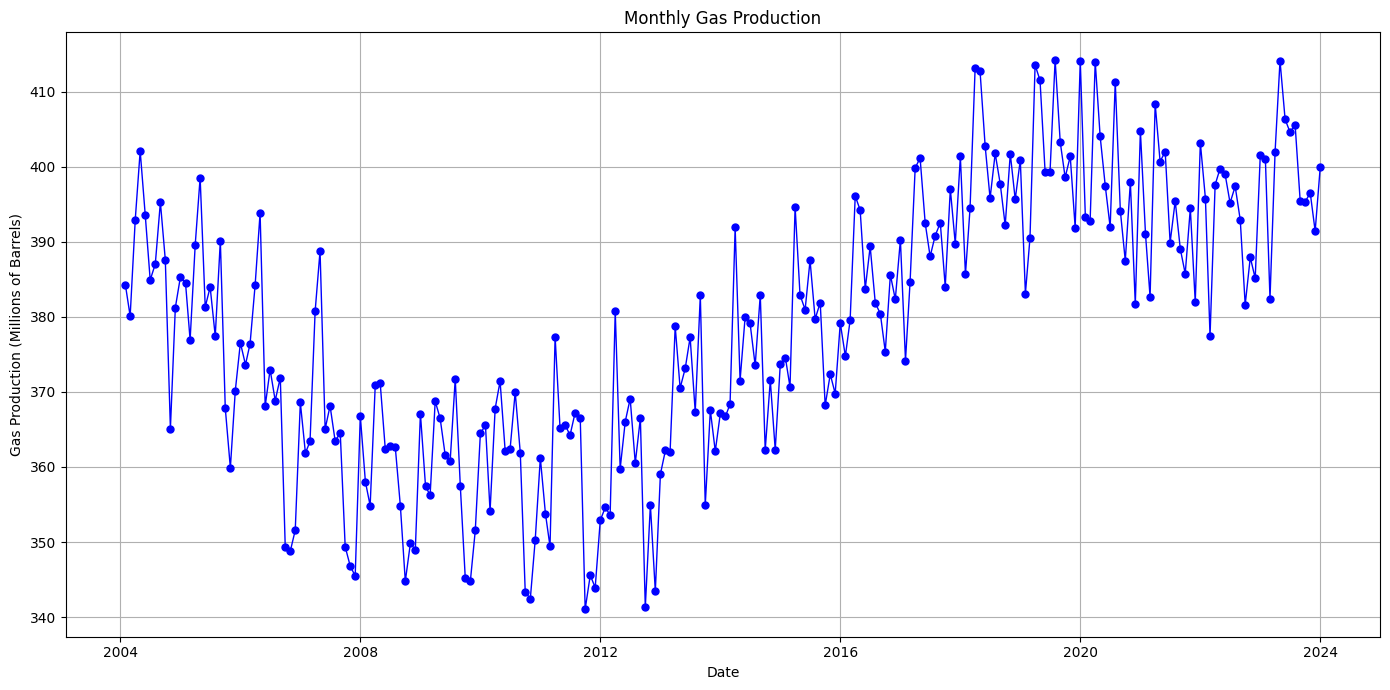

In [5]:
# Convert "Month" column to proper date column of equal monthly intervals
df['Date'] = pd.date_range(start='2004-01', periods=len(df), freq='M')

# Set Date as the index
df.set_index('Date', inplace=True)

# Generate plot of monthly gas production
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Gas_prod'], color='blue', marker='o', linestyle='-', linewidth=1, markersize=5)
plt.title('Monthly Gas Production')
plt.xlabel('Date')
plt.ylabel('Gas Production (Millions of Barrels)')
plt.grid(True)
plt.tight_layout()

plt.show()

# **2. Split the data into training and validation sets.  Use the last three years of data for validation set and the remaining as the training set. Run the following forecasting models. (5)**

In [7]:
# Splitting the data into training and validation sets
# Last three years for validation set, remaining for training set

# Extracting the start date for the validation set (last three years)
validation_start_date = '2021-01'

# Creating training and validation sets
df_train = df[:validation_start_date]
df_validation = df[validation_start_date:]

# Checking the first and last few rows of the training set to confirm the split
df_train.tail(), df_validation.head()

(            Month    Gas_prod
 Date                         
 2020-09-30    201  387.490469
 2020-10-31    202  397.962931
 2020-11-30    203  381.649235
 2020-12-31    204  404.797976
 2021-01-31    205  391.083819,
             Month    Gas_prod
 Date                         
 2021-01-31    205  391.083819
 2021-02-28    206  382.657921
 2021-03-31    207  408.382013
 2021-04-30    208  400.703560
 2021-05-31    209  402.013385)

## (a)  Linear trend

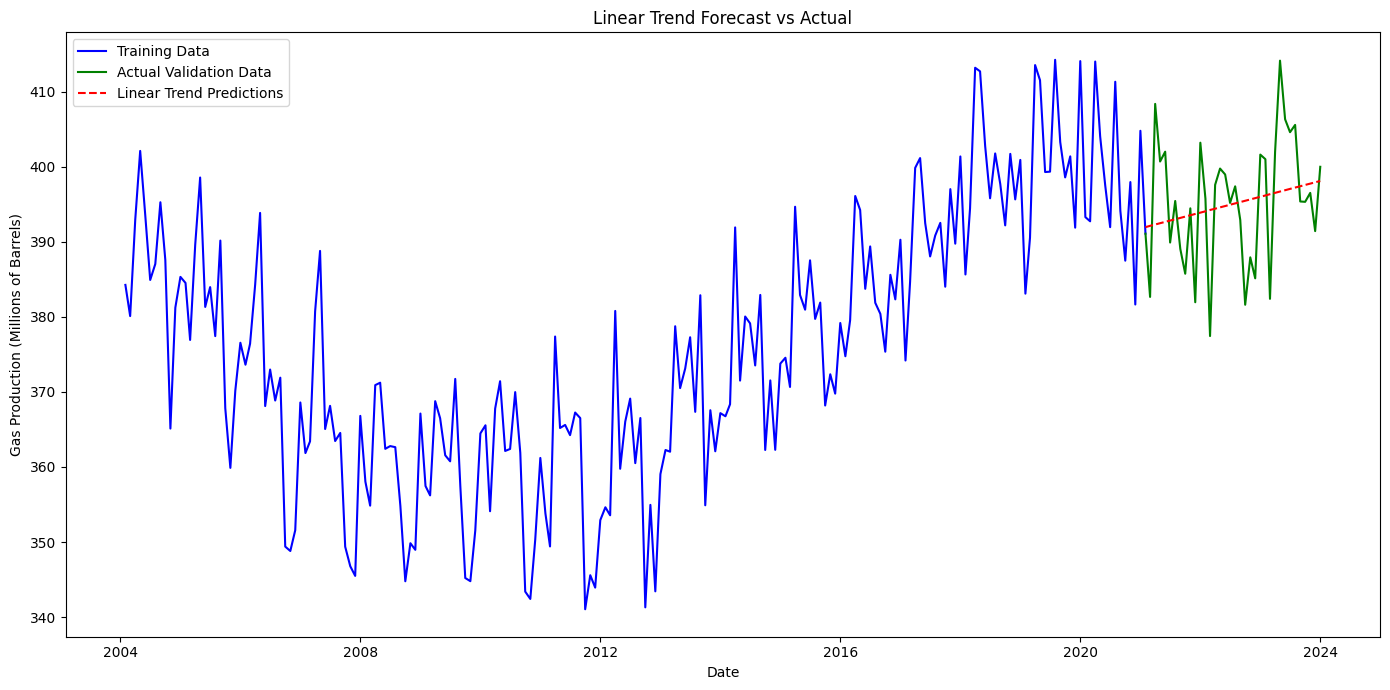

(66.45154740296756, 6.608047745539935, 0.05371641590703491)

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Decompose the series to identify trend
result = seasonal_decompose(df_train['Gas_prod'], model='additive', period=12)

# Prepare the trend component for modeling, removing NaN values that result from decomposition
trend = result.trend.dropna()
trend_index = np.arange(len(trend)).reshape(-1, 1)  # Use a simple index for the trend component

# Linear Trend Model
model_linear_trend = LinearRegression()
model_linear_trend.fit(trend_index, trend)

# Predict using the model
trend_pred_index = np.arange(len(trend), len(trend) + len(df_validation)).reshape(-1, 1)
linear_trend_predictions = model_linear_trend.predict(trend_pred_index)

# Plotting the linear trend predictions along with actual data
plt.figure(figsize=(14, 7))
plt.plot(df_train.index, df_train['Gas_prod'], label='Training Data', color='blue')
plt.plot(df_validation.index, df_validation['Gas_prod'], label='Actual Validation Data', color='green')
plt.plot(df_validation.index, linear_trend_predictions, label='Linear Trend Predictions', color='red', linestyle='--')
plt.title('Linear Trend Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Gas Production (Millions of Barrels)')
plt.legend()
plt.tight_layout()

plt.show()

# Calculate and display metrics for linear trend model
mse = mean_squared_error(df_validation['Gas_prod'], linear_trend_predictions)
mae = mean_absolute_error(df_validation['Gas_prod'], linear_trend_predictions)
r2 = r2_score(df_validation['Gas_prod'], linear_trend_predictions)

mse, mae, r2


## (b)  Seasonality

## (c)  Quadratic trend and seasonality (remember that quadratic trend includes a linear trend term)

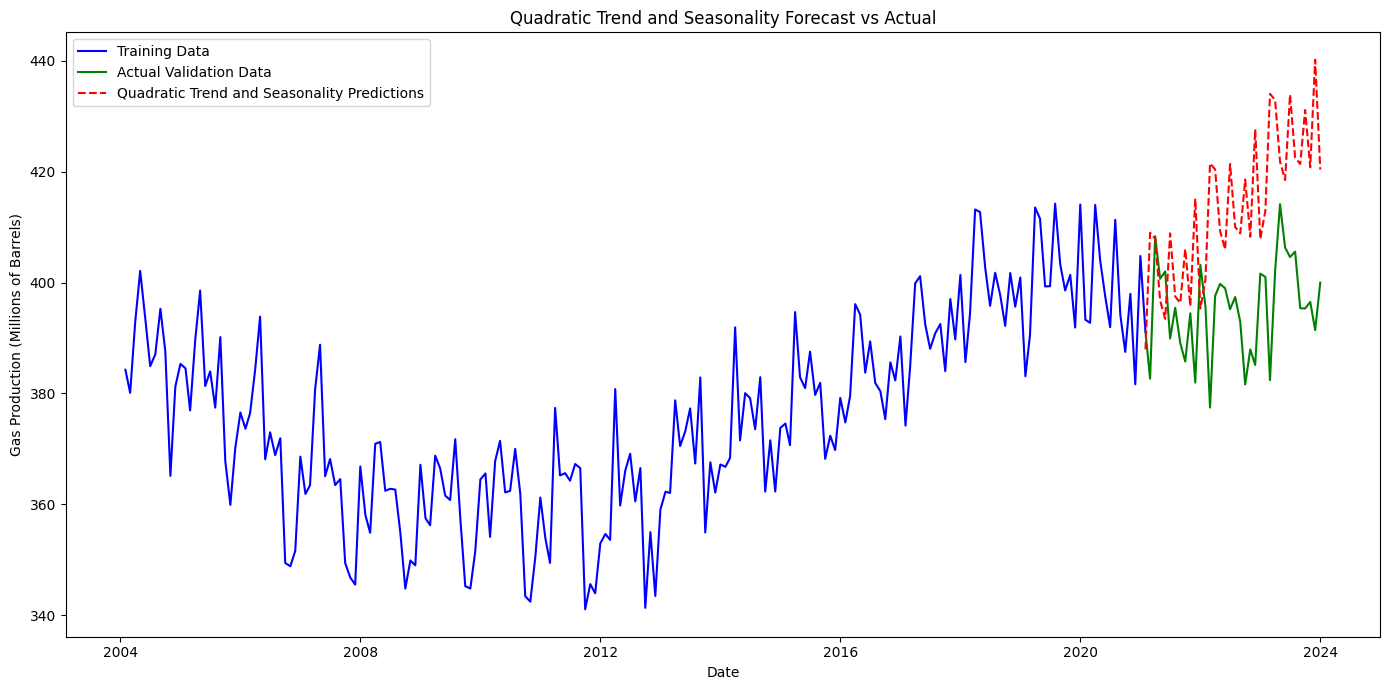

(573.0189856290409, 19.41127996253515, -7.159907190515613)

In [9]:
from statsmodels.tsa.seasonal import STL

# Using STL to decompose for a more flexible seasonal component
stl = STL(df_train['Gas_prod'], seasonal=13)
result = stl.fit()

# Extract the trend and seasonal components
trend_component = result.trend
seasonal_component = result.seasonal

# Prepare the data for the Quadratic Trend Model including seasonality
df_train_processed = pd.DataFrame({
    'Trend': trend_component,
    'Seasonal': seasonal_component,
    'Trend_squared': np.arange(len(trend_component))**2  # Quadratic term
}).dropna()

# Define predictors and response
X_train = df_train_processed[['Trend', 'Trend_squared', 'Seasonal']]
y_train = df_train['Gas_prod'][-len(X_train):]

# Quadratic Trend and Seasonality Model
model_quad_trend_seasonality = LinearRegression()
model_quad_trend_seasonality.fit(X_train, y_train)

# Predictions
# Generating the same components for the validation period
X_validation = pd.DataFrame({
    'Trend': np.linspace(X_train['Trend'].iloc[-1], X_train['Trend'].iloc[-1] + len(df_validation), len(df_validation)),
    'Trend_squared': np.linspace(X_train['Trend_squared'].iloc[-1], X_train['Trend_squared'].iloc[-1] + len(df_validation)**2, len(df_validation)),
    'Seasonal': np.tile(seasonal_component[-12:], int(np.ceil(len(df_validation)/12)))[:len(df_validation)]  # Repeating the last year's seasonality
})

quad_trend_seasonality_predictions = model_quad_trend_seasonality.predict(X_validation)

# Plotting the quadratic trend and seasonality predictions along with actual data
plt.figure(figsize=(14, 7))
plt.plot(df_train.index, df_train['Gas_prod'], label='Training Data', color='blue')
plt.plot(df_validation.index, df_validation['Gas_prod'], label='Actual Validation Data', color='green')
plt.plot(df_validation.index, quad_trend_seasonality_predictions, label='Quadratic Trend and Seasonality Predictions', color='red', linestyle='--')
plt.title('Quadratic Trend and Seasonality Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Gas Production (Millions of Barrels)')
plt.legend()
plt.tight_layout()

plt.show()

# Calculate and display metrics for quadratic trend and seasonality model
mse_quad = mean_squared_error(df_validation['Gas_prod'], quad_trend_seasonality_predictions)
mae_quad = mean_absolute_error(df_validation['Gas_prod'], quad_trend_seasonality_predictions)
r2_quad = r2_score(df_validation['Gas_prod'], quad_trend_seasonality_predictions)

mse_quad, mae_quad, r2_quad


## **3. In the Word document, write a short paragraph for each model about the model performance using any three metrics.  Which model performs best?  Justify your answer. (15)**

# **4. Take the gas_prod for any 12 consecutive months from the dataset.  In the Word document, show in a table the original gas_prod values, a simple moving average forecast with 6-month rolling period, and an exponential smoothing forecast with alpha=0.2. (5)**

# **5. Build and run a forecasting model using SARIMA.  Explain the process of choosing the values for p, d, and q for the SARIMA model (Use ACF and PACF plots; Do not use the automated search algorithm to pick the best SARIMA parameters). Write a paragraph commenting on the SARIMA results, including the model performance and the AR and MA parameters.  (15)**

# **6. Compare the best model chosen from step 3 with the SARIMA model.  Which model is better for forecasting between the two?  Justify your answer. (5)**